In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import kagglehub

The dataset is located at https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud. It is larger than GitHub's maximum allowed file size 100mb, so for this project we have downloaded and extracted it.

In [2]:
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

# The CSV file inside that directory
csv_path = path + "/creditcard.csv"

df = pd.read_csv(csv_path)

df.shape

(284807, 31)

**Inspect Dataset Structure**

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
# Counts of each class
class_counts = df['Class'].value_counts().sort_index()
class_counts

Class
0    284315
1       492
Name: count, dtype: int64

In [6]:
# Check for duplicate rows
num_duplicates = df.duplicated().sum()
num_duplicates

np.int64(1081)

In [7]:
# Remove duplicates
df = df.drop_duplicates().reset_index(drop=True)

print("New shape after removing duplicates:", df.shape)

New shape after removing duplicates: (283726, 31)


**Class Imbalance Recheck**

After removing duplicates, we reconfirm the number of legitimate vs. fraudulent transactions and plot visualisations.

In [8]:
# Basic counts of each class
class_counts = df['Class'].value_counts().sort_index()
class_counts

Class
0    283253
1       473
Name: count, dtype: int64

In [9]:
def plot_class_distribution(labels, title_prefix="Dataset"):
    counts = pd.Series(labels).value_counts().sort_index()

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    counts.plot(kind='bar', color=['steelblue', 'salmon'])
    plt.title(f'{title_prefix}: Class Distribution (0 = Legitimate, 1 = Fraud)')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)

    plt.subplot(1, 2, 2)
    counts.plot(
        kind='pie',
        autopct='%1.2f%%',
        startangle=90,
        colors=['steelblue', 'salmon'],
        labels=['Legitimate', 'Fraud']
    )
    plt.ylabel('')
    plt.title(f'{title_prefix}: Class Percent')

    plt.tight_layout()
    plt.show()

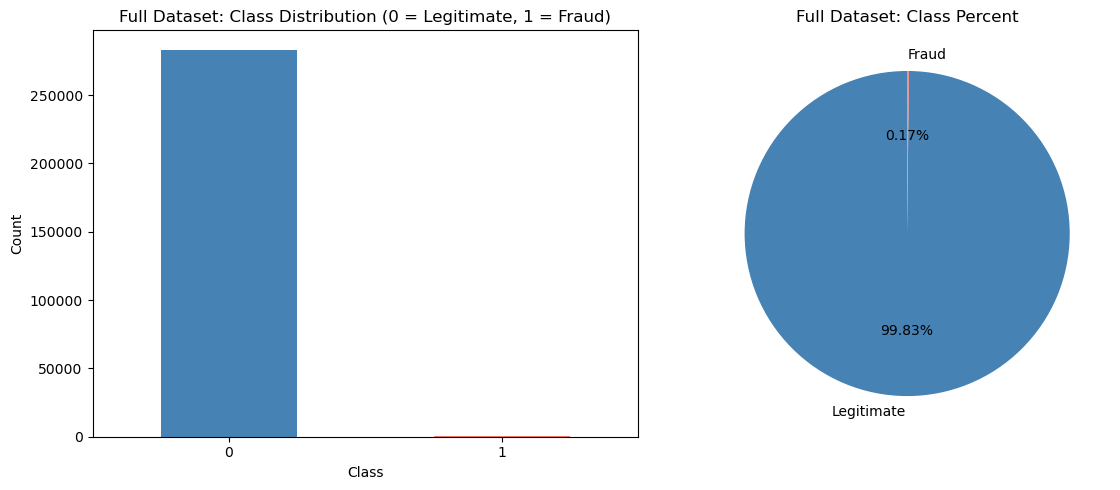

In [10]:
plot_class_distribution(df['Class'], title_prefix="Full Dataset")

**Boxplots for Detecting Outliers**

Because transaction amounts can vary widely and may include extreme outliers, we include boxplots to visualize the distribution of `Amount`. Outliers are common in financial datasets and can be informative for fraud detection, since fraudulent transactions sometimes involve unusually high or low amounts. We generate a class-separated boxplot (legitimate vs. fraud) to compare distributions.

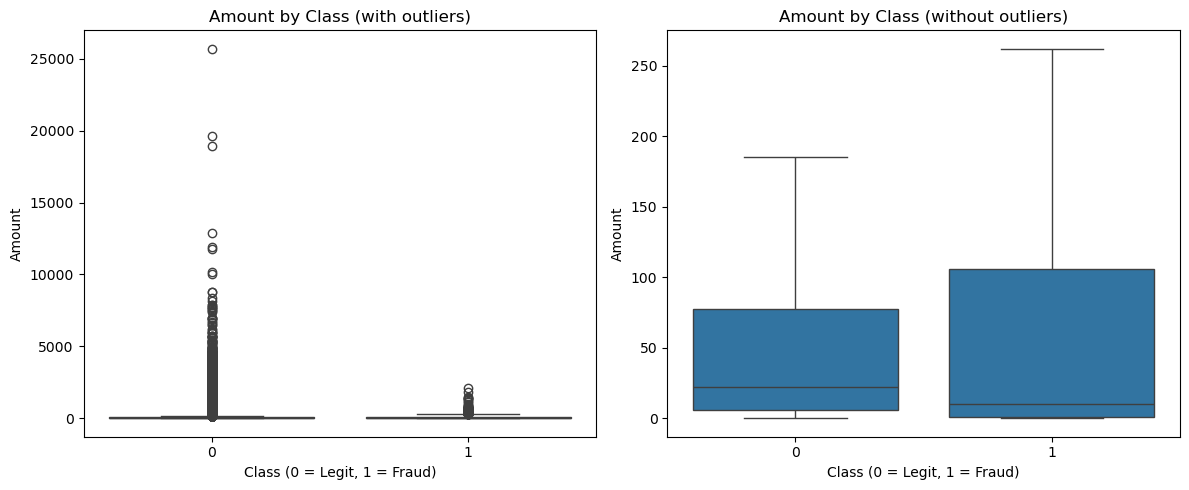

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

# With outliers
sns.boxplot(ax=ax1, x='Class', y='Amount', data=df, showfliers=True)
ax1.set_title('Amount by Class (with outliers)')
ax1.set_xlabel('Class (0 = Legit, 1 = Fraud)')
ax1.set_ylabel('Amount')

# Without outliers
sns.boxplot(ax=ax2, x='Class', y='Amount', data=df, showfliers=False)
ax2.set_title('Amount by Class (without outliers)')
ax2.set_xlabel('Class (0 = Legit, 1 = Fraud)')
ax2.set_ylabel('Amount')

plt.tight_layout()
plt.show()

**Preparing Features and Target**

To begin the modeling pipeline, we separate the dataset into input features and the target label:

- X: all feature columns except the target  
- y: fraud label (Class), where 1 = fraud and 0 = legitimate  


In [12]:
# Separate features and target
X = df.drop("Class", axis=1)
y = df["Class"]

X.shape, y.shape

((283726, 30), (283726,))

**Train/Test Split**

We use a stratified train/test split so that both sets preserve the extreme class imbalance present in the dataset. Without stratification, the test set could easily end up with very few or even zero fraud cases, leading to unreliable evaluation results.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((241167, 30), (42559, 30))

**Scale After Splitting**

Feature scaling must be performed after the train/test split to avoid data leakage.  
If we scale the entire dataset before splitting, the scaling parameters (mean and standard deviation) would be influenced by the test data, giving the model unfair prior knowledge about values it should never see during training.

By fitting the scaler only on the training set and applying the transformation to the test set, we maintain a realistic evaluation scenario that reflects how the model would behave on new, unseen transactions.

We will scale Time and Amount, which are not PCA-transformed and typically need normalization.

In [14]:
# Initialize scaler
scaler = StandardScaler()

# Copy training and test sets to avoid modifying the original dataframe
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Fit scaler only on training data
X_train_scaled[['Time', 'Amount']] = scaler.fit_transform(X_train[['Time', 'Amount']])

# Transform test data using parameters learned from training data
X_test_scaled[['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])

X_train_scaled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
83897,-0.729921,1.233270,0.040032,0.134008,0.272556,0.054883,0.244832,-0.223827,0.205438,0.030645,...,-0.170326,-0.247630,-0.773342,0.067363,-0.848483,0.182254,0.162467,-0.025604,-0.005840,-0.357555
171814,0.552718,-0.783823,0.927366,-1.043634,1.065041,2.369544,-0.542584,1.287016,-0.239198,-0.713867,...,0.099626,-0.040171,0.392896,0.202957,-0.071165,0.310242,-0.355486,0.406562,0.220590,-0.357106
98390,-0.590880,1.266865,0.481231,-0.119466,1.112353,0.026039,-1.193853,0.555428,-0.354063,-0.271385,...,-0.148044,0.005526,0.059630,-0.149126,0.405325,0.848880,-0.296838,-0.009259,0.011754,-0.333457
258577,1.354107,-2.083682,2.108832,-2.223863,-0.015583,-0.431835,-1.695080,-0.477952,1.284506,-0.298766,...,-0.502417,0.377555,0.998111,0.182312,-0.076132,-0.136755,-0.148385,-0.307083,-0.069161,-0.352409
133634,-0.299110,-1.760925,1.387821,-0.050880,1.336324,-2.605606,1.388641,1.783186,0.726618,-0.684235,...,-0.260697,-0.044770,0.372187,0.151773,0.247016,-0.023620,-0.235129,0.459238,-0.043548,1.528775


**Baseline Modeling**

Before applying any resampling methods, we train baseline models on the original imbalanced dataset. This gives us a reference point to evaluate how much SMOTE or class-weighting improves performance later.

We evaluate the following models:

- Logistic Regression
- Random Forest
- XGBoost

Because accuracy is misleading under extreme imbalance, we evaluate models using:

- Precision
- Recall
- F1-score
- ROC-AUC


**Functions for collecting metrics to summarize together**

In [15]:
def get_metrics(model, X_test, y_test, name):
    """Collect precision, recall, F1-score, ROC-AUC, and AUPRC for a model."""
    y_pred = model.predict(X_test)

    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        roc = float(roc_auc_score(y_test, y_proba))
        auprc = float(average_precision_score(y_test, y_proba))
    except AttributeError:
        roc = None
        auprc = None

    precision = precision_score(y_test, y_pred, average=None, zero_division=0)
    recall = recall_score(y_test, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_test, y_pred, average=None, zero_division=0)

    return {
        "Model": name,
        "Precision": {cls: float(val) for cls, val in enumerate(precision)},
        "Recall": {cls: float(val) for cls, val in enumerate(recall)},
        "F1": {cls: float(val) for cls, val in enumerate(f1)},
        "ROC_AUC": roc,
        "AUPRC": auprc
    }

In [16]:
from sklearn.metrics import confusion_matrix

def get_costs(model, X_test_scaled, X_test_original, y_test, name, fp_cost=25.0):
    """
    Compute cost-based metrics:
      - Missed fraud dollar amount (sum of Amount for False Negatives)
      - Investigation cost for False Postives (fp_cost per False Positive)
      - Total cost = FN_loss + FP_cost_total
    """
    # Predictions on scaled features
    y_pred = model.predict(X_test_scaled)

    # Confusion matrix to get counts
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()

    # Masks to find which rows are False Negative and False Positive
    fn_mask = (y_test == 1) & (y_pred == 0)
    fp_mask = (y_test == 0) & (y_pred == 1)

    # Use the original (unscaled) Amount column
    # Make sure indices align
    amounts = X_test_original["Amount"]

    missed_fraud_amount = amounts[fn_mask].sum()         # Money lost from False Negatives
    investigation_cost = fp_cost * fp_mask.sum()         # cost of investigating False Positives
    total_cost = missed_fraud_amount + investigation_cost

    return {
        "Model": name,
        "FN_count": int(fn),
        "FP_count": int(fp),
        "Missed_Fraud_$": float(missed_fraud_amount),
        "Investigation_$": float(investigation_cost),
        "Total_Cost_$": float(total_cost),
    }


In [17]:
def evaluate_models_dict(models_dict, X_test, y_test, label_suffix=""):
    """Evaluate each model and format per-class metrics for compact display."""
    def _format_pair(values, precision=4):
        return " | ".join(f"{cls}: {val:.{precision}f}" for cls, val in values.items())

    results = []
    for name, model in models_dict.items():
        full_name = f"{name} - {label_suffix}" if label_suffix else name
        metrics = get_metrics(model, X_test, y_test, full_name)

        metrics["Precision"] = _format_pair(metrics["Precision"])
        metrics["Recall"] = _format_pair(metrics["Recall"])
        metrics["F1"] = _format_pair(metrics["F1"])
        metrics["ROC_AUC"] = None if metrics["ROC_AUC"] is None else f"{metrics['ROC_AUC']:.4f}"
        metrics["AUPRC"] = None if metrics["AUPRC"] is None else f"{metrics['AUPRC']:.4f}"

        results.append(metrics)

    return pd.DataFrame(results)

In [18]:
def evaluate_models_cost(models_dict, X_test_scaled, X_test_original, y_test, fp_cost=25.0, label_suffix=""):
    """
    Evaluating a dict of models with cost-based metrics.
    models_dict: {"LogReg": model_obj, "RF": model_obj, ...}
    """
    results = []

    for name, model in models_dict.items():
        full_name = f"{name} - {label_suffix}" if label_suffix else name
        cost_metrics = get_costs(
            model,
            X_test_scaled=X_test_scaled,
            X_test_original=X_test_original,
            y_test=y_test,
            name=full_name,
            fp_cost=fp_cost
        )
        results.append(cost_metrics)

    return pd.DataFrame(results)

**Model 1 - Logistic Regression**

In [19]:
log_reg = LogisticRegression(max_iter=1000, class_weight=None) # class weight set to None for baseline
log_reg.fit(X_train_scaled, y_train)

get_metrics(log_reg, X_test_scaled, y_test, "Logistic Regression (Baseline)")

{'Model': 'Logistic Regression (Baseline)',
 'Precision': {0: 0.9993413004610897, 1: 0.8431372549019608},
 'Recall': {0: 0.9998117115420825, 1: 0.6056338028169014},
 'F1': {0: 0.9995764506565015, 1: 0.7049180327868853},
 'ROC_AUC': 0.9584545495530138,
 'AUPRC': 0.684404465501752}

**Model 2 - Random Forest**

In [21]:
rf = RandomForestClassifier(
    warm_start=True,
    n_estimators=200,
    random_state=42,
    class_weight=None,  # baseline: no imbalance handling
    n_jobs=-1           # parallelize across all CPU cores
)

rf.fit(X_train_scaled, y_train)

get_metrics(rf, X_test_scaled, y_test, "Random Forest (Baseline)")

{'Model': 'Random Forest (Baseline)',
 'Precision': {0: 0.9995765104460757, 1: 0.9636363636363636},
 'Recall': {0: 0.9999529278855206, 1: 0.7464788732394366},
 'F1': {0: 0.9997646837349398, 1: 0.8412698412698413},
 'ROC_AUC': 0.9267511489573859,
 'AUPRC': 0.7948019548741401}

**Model 3 - XGBoost**

In [22]:
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    scale_pos_weight=1,  # baseline: no imbalance handling
    n_jobs=-1          # parallelize across all CPU cores
)

xgb.fit(X_train_scaled, y_train)

get_metrics(xgb, X_test_scaled, y_test, "XGBoost (Baseline)")

{'Model': 'XGBoost (Baseline)',
 'Precision': {0: 0.9996235294117647, 1: 0.9322033898305084},
 'Recall': {0: 0.9999058557710412, 1: 0.7746478873239436},
 'F1': {0: 0.9997646726596696, 1: 0.8461538461538461},
 'ROC_AUC': 0.9732477902625696,
 'AUPRC': 0.8354777577349422}

**Baseline Results Summary**

These baseline results show how each model performs on the unbalanced dataset.
Because fraud cases are extremely rare, models typically exhibit high precision but very low recall (they miss most fraud cases).

In [23]:
baseline_models = {
    "LogReg": log_reg,
    "RandomForest": rf,
    "XGBoost": xgb
}

baseline_results = evaluate_models_dict(
    baseline_models,
    X_test_scaled,
    y_test,
    label_suffix="Baseline"
)

baseline_results


,Model,Precision,Recall,F1,ROC_AUC,AUPRC
0,LogReg - Baseline,0: 0.9993 | 1: 0.8431,0: 0.9998 | 1: 0.6056,0: 0.9996 | 1: 0.7049,0.9585,0.6844
1,RandomForest - Baseline,0: 0.9996 | 1: 0.9636,0: 1.0000 | 1: 0.7465,0: 0.9998 | 1: 0.8413,0.9268,0.7948
2,XGBoost - Baseline,0: 0.9996 | 1: 0.9322,0: 0.9999 | 1: 0.7746,0: 0.9998 | 1: 0.8462,0.9732,0.8355


**Modeling with SMOTE (Handling Class Imbalance)**

Next, we apply SMOTE (Synthetic Minority Oversampling Technique) to address the extreme class imbalance in the training data. SMOTE creates synthetic minority (fraud) examples by interpolating between existing ones.

Important points:

- SMOTE is applied only to the training set (X_train_scaled, y_train).
- The test set is left untouched so that evaluation reflects real-world, imbalanced data.
- We retrain the same models (Logistic Regression, Random Forest, XGBoost) on the SMOTE-balanced training data and compare their performance to the baseline models.


In [24]:
sm = SMOTE(random_state=42)

X_train_smote, y_train_smote = sm.fit_resample(X_train_scaled, y_train)

X_train_scaled.shape, y_train.shape, X_train_smote.shape, y_train_smote.shape

((241167, 30), (241167,), (481530, 30), (481530,))

In [25]:
y_train.value_counts(), y_train_smote.value_counts()

(Class
 0    240765
 1       402
 Name: count, dtype: int64,
 Class
 0    240765
 1    240765
 Name: count, dtype: int64)

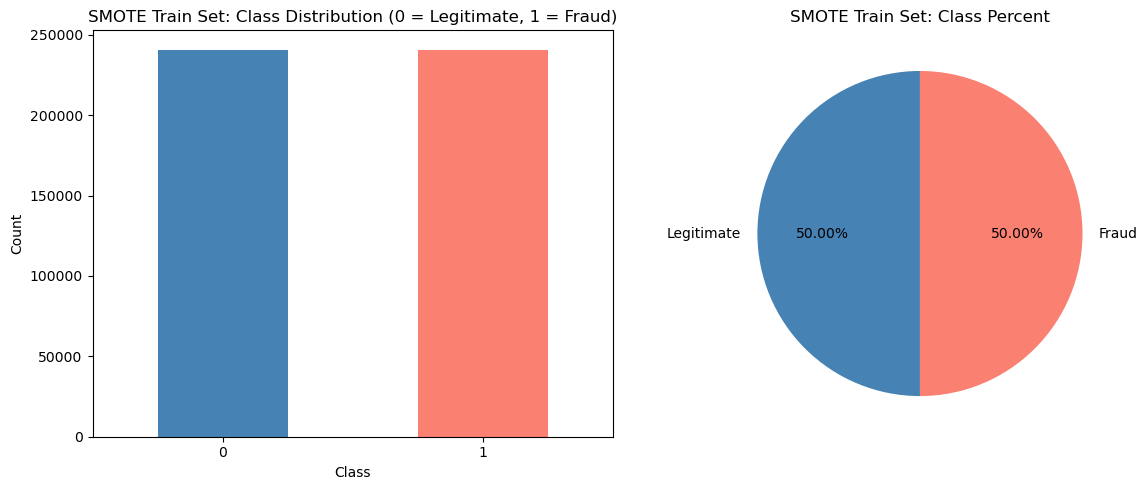

In [26]:
plot_class_distribution(y_train_smote, title_prefix="SMOTE Train Set")

**Model 1 - Logistic Regression with SMOTE**

In [27]:
log_reg_smote = LogisticRegression(max_iter=1000)

log_reg_smote.fit(X_train_smote, y_train_smote)

get_metrics(log_reg_smote, X_test_scaled, y_test, "Logistic Regression (SMOTE)")

{'Model': 'Logistic Regression (SMOTE)',
 'Precision': {0: 0.9997584832749667, 1: 0.05285961871750433},
 'Recall': {0: 0.9742750894370175, 1: 0.8591549295774648},
 'F1': {0: 0.9868522999535122, 1: 0.09959183673469388},
 'ROC_AUC': 0.9640190038744991,
 'AUPRC': 0.6443894395400659}

**Model 2 - Random Forest with SMOTE**

In [28]:
rf_smote = RandomForestClassifier(
    warm_start=True,
    n_estimators=200,
    random_state=42,
    n_jobs=-1  # parallelize
)

rf_smote.fit(X_train_smote, y_train_smote)

get_metrics(rf_smote, X_test_scaled, y_test, "Random Forest (SMOTE)")

{'Model': 'Random Forest (SMOTE)',
 'Precision': {0: 0.9996234939759037, 1: 0.873015873015873},
 'Recall': {0: 0.9998117115420825, 1: 0.7746478873239436},
 'F1': {0: 0.9997175939000282, 1: 0.8208955223880597},
 'ROC_AUC': 0.961125063315309,
 'AUPRC': 0.7991933568573852}

**Model 3 - XGBoost with SMOTE**

In [29]:
xgb_smote = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    n_jobs=-1
)

xgb_smote.fit(X_train_smote, y_train_smote)

get_metrics(xgb_smote, X_test_scaled, y_test, "XGBoost (SMOTE)")

{'Model': 'XGBoost (SMOTE)',
 'Precision': {0: 0.9996938583270535, 1: 0.6105263157894737},
 'Recall': {0: 0.9991291658821314, 1: 0.8169014084507042},
 'F1': {0: 0.9994114323382616, 1: 0.6987951807228916},
 'ROC_AUC': 0.9780665493620735,
 'AUPRC': 0.804197001316244}

**SMOTE vs. Baseline Comparison**

Comparing SMOTE-balanced models to their baselines highlights the usual fraud-detection trade-off:

- Recall generally rises after SMOTE, so more fraudulent transactions are caught.
- Precision often drops a bit because oversampling produces more false positives.
- F1 improves when the recall gain outweighs the precision loss.
- ROC-AUC may stay flat or inch upward depending on the model.
- *Note:* Because fraud cases are extremely rare, AUPRC is a more telling summary than ROC-AUC. A random classifier would still post a high ROC-AUC under extreme imbalance, but its AUPRC equals the fraud prevalence (≈0.17%), so any lift in AUPRC directly signals better minority-class detection.

This cost–benefit balance drives which model you pick: missed fraud (low recall) is expensive, but too many false positives strain investigators. Choose the model whose recall–precision balance best matches the business risk tolerance.


In [30]:
all_models = {
    "LogReg": log_reg,
    "LogReg - SMOTE": log_reg_smote,
    "RF": rf,
    "RF - SMOTE": rf_smote,
    "XGBoost": xgb,
    "XGBoost - SMOTE": xgb_smote
}

all_results = evaluate_models_dict(
    all_models,
    X_test_scaled,
    y_test,
    label_suffix=""
)

all_results

,Model,Precision,Recall,F1,ROC_AUC,AUPRC
0,LogReg,0: 0.9993 | 1: 0.8431,0: 0.9998 | 1: 0.6056,0: 0.9996 | 1: 0.7049,0.9585,0.6844
1,LogReg - SMOTE,0: 0.9998 | 1: 0.0529,0: 0.9743 | 1: 0.8592,0: 0.9869 | 1: 0.0996,0.9640,0.6444
2,RF,0: 0.9996 | 1: 0.9636,0: 1.0000 | 1: 0.7465,0: 0.9998 | 1: 0.8413,0.9268,0.7948
3,RF - SMOTE,0: 0.9996 | 1: 0.8730,0: 0.9998 | 1: 0.7746,0: 0.9997 | 1: 0.8209,0.9611,0.7992
4,XGBoost,0: 0.9996 | 1: 0.9322,0: 0.9999 | 1: 0.7746,0: 0.9998 | 1: 0.8462,0.9732,0.8355
5,XGBoost - SMOTE,0: 0.9997 | 1: 0.6105,0: 0.9991 | 1: 0.8169,0: 0.9994 | 1: 0.6988,0.9781,0.8042


In [31]:
# Setting an investigation cost per false positive
fp_cost = 25.0

cost_results = evaluate_models_cost(
    all_models,
    X_test_scaled=X_test_scaled,
    X_test_original=X_test,  # unscaled, has real Amount
    y_test=y_test,
    fp_cost=fp_cost
)

# Sort by lowest total cost (best model at top)
cost_results_sorted = cost_results.sort_values(by="Total_Cost_$")
cost_results_sorted


,Model,FN_count,FP_count,Missed_Fraud_$,Investigation_$,Total_Cost_$
4,XGBoost,16,4,2314.57,100.0,2414.57
2,RF,18,2,2554.50,50.0,2604.50
5,XGBoost - SMOTE,13,37,2525.69,925.0,3450.69
3,RF - SMOTE,16,8,4358.20,200.0,4558.20
0,LogReg,28,8,6151.95,200.0,6351.95
1,LogReg - SMOTE,10,1093,2276.76,27325.0,29601.76


In [32]:
def plot_feature_importances_comparison(baseline_model, smote_model, X_train, model_name, top_n=10):
    """
    Show side-by-side feature-importance bar charts for a baseline model and its SMOTE-trained counterpart.
    """
    model_frames = {}
    for label, model in [("Baseline", baseline_model), ("SMOTE", smote_model)]:
        model_frames[label] = (
            pd.DataFrame({"Feature": X_train.columns, "Importance": model.feature_importances_})
            .sort_values(by="Importance", ascending=False)
        )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
    sns.barplot(data=model_frames["Baseline"].head(top_n), x="Importance", y="Feature",
                hue="Feature", palette="viridis", legend=False, ax=ax1)
    ax1.set_title(f"Top {top_n} {model_name} (Baseline)")

    sns.barplot(data=model_frames["SMOTE"].head(top_n), x="Importance", y="Feature",
                hue="Feature", palette="viridis", legend=False, ax=ax2)
    ax2.set_title(f"Top {top_n} {model_name} (SMOTE)")

    plt.tight_layout()
    plt.show()

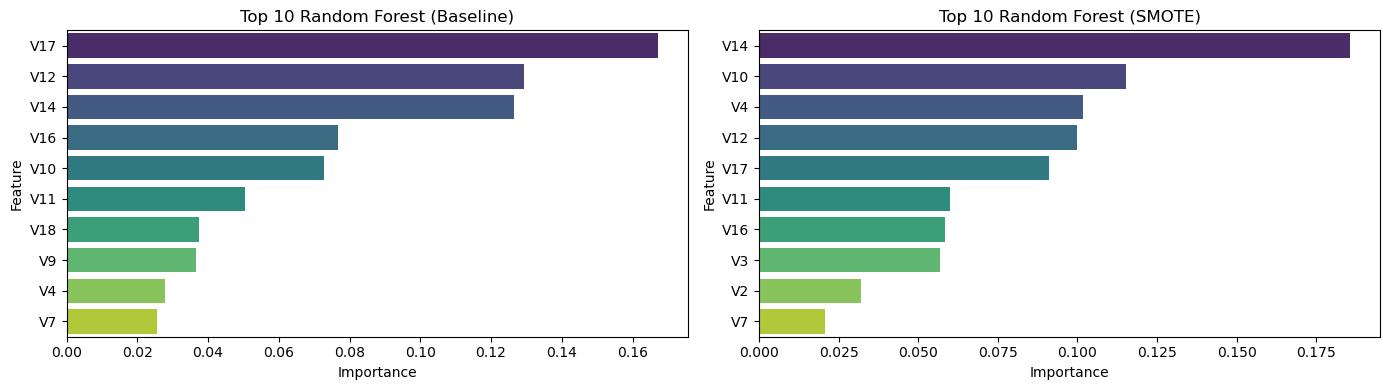

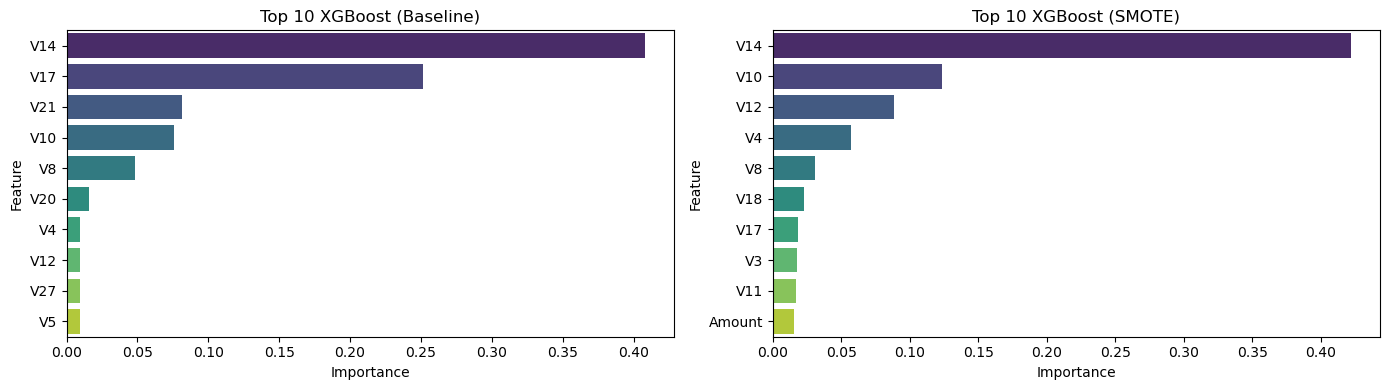

In [ ]:
# Compare Random Forest
plot_feature_importances_comparison(rf, rf_smote, X_train_scaled, "Random Forest")

# Compare XGBoost
plot_feature_importances_comparison(xgb, xgb_smote, X_train_scaled, "XGBoost")



In [ ]:
# Pipeline: SMOTE -> Random Forest
rf_pipeline = Pipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        max_features="sqrt"
    ))
])
# Hyperparameters for the RF step
param_dist = {
    "rf__n_estimators": randint(80, 181),       # 80–180 trees
    "rf__max_depth": [None, 8, 12],             
    "rf__min_samples_split": randint(2, 8),     # 2–7
    "rf__min_samples_leaf": randint(1, 4)     # keep 1–3/4      # fewer options, still meaningful
}

rand_search_rf = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring="average_precision",  # AUPRC
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# X_train, y_train (no SMOTE applied yet)
rand_search_rf.fit(X_train_scaled, y_train)

best_rf_pipeline = rand_search_rf.best_estimator_
rand_search_rf.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'rf__max_depth': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 137}

In [35]:
get_metrics(best_rf_pipeline, X_test_scaled, y_test, "RF Tuned Pipeline")

{'Model': 'RF Tuned Pipeline',
 'Precision': {0: 0.9995764506565015, 1: 0.8688524590163934},
 'Recall': {0: 0.9998117115420825, 1: 0.7464788732394366},
 'F1': {0: 0.9996940672581366, 1: 0.803030303030303},
 'ROC_AUC': 0.9690431233607635,
 'AUPRC': 0.817086132167466}

In [ ]:
# Base XGBoost model similar to xgb_smote
xgb_base = XGBClassifier(
    eval_metric="logloss",
    n_jobs=-1
)

# Compact search space
param_dist_xgb = {
    "n_estimators": randint(150, 261),         # around 200 (150–260)
    "max_depth": randint(4, 9),               # around 6 (4–8)
    "learning_rate": uniform(0.05, 0.11),     # around 0.1 (0.05–0.16)
    "subsample": uniform(0.7, 0.3),           # 0.7–1.0 (around 0.8)
    "colsample_bytree": uniform(0.7, 0.3)     # 0.7–1.0 (around 0.8)
}

xgb_rand_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist_xgb,
    n_iter=15,                     
    scoring="average_precision",  # AUPRC
    cv=3,                         
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit on SMOTE-balanced training data (just like xgb_smote)
xgb_rand_search.fit(X_train_smote, y_train_smote)

best_xgb = xgb_rand_search.best_estimator_
xgb_rand_search.best_params_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


{'colsample_bytree': np.float64(0.8400288679743939),
 'learning_rate': np.float64(0.14459344474099528),
 'max_depth': 8,
 'n_estimators': 222,
 'subsample': np.float64(0.7195154778955838)}

In [45]:
get_metrics(best_xgb, X_test_scaled, y_test, "XGBoost (SMOTE + RandomizedSearch)")

{'Model': 'XGBoost (SMOTE + RandomizedSearch)',
 'Precision': {0: 0.9996704564178612, 1: 0.75},
 'Recall': {0: 0.9995528149124459, 1: 0.8028169014084507},
 'F1': {0: 0.9996116322039283, 1: 0.7755102040816326},
 'ROC_AUC': 0.9712014792577722,
 'AUPRC': 0.8159224490494584}

In [46]:
all_models = {
    "LogReg": log_reg,
    "LogReg - SMOTE": log_reg_smote,
    "RF": rf,
    "RF - SMOTE": rf_smote,
    "XGBoost": xgb,
    "XGBoost - SMOTE": xgb_smote,
    "RF - Tuned Pipeline": best_rf_pipeline,
    "XGBoost - SMOTE + RandomizedSearch": best_xgb
}

all_results = evaluate_models_dict(
    all_models,
    X_test_scaled,
    y_test,
    label_suffix=""
)

all_results

,Model,Precision,Recall,F1,ROC_AUC,AUPRC
0,LogReg,0: 0.9993 | 1: 0.8431,0: 0.9998 | 1: 0.6056,0: 0.9996 | 1: 0.7049,0.9585,0.6844
1,LogReg - SMOTE,0: 0.9998 | 1: 0.0529,0: 0.9743 | 1: 0.8592,0: 0.9869 | 1: 0.0996,0.9640,0.6444
2,RF,0: 0.9996 | 1: 0.9636,0: 1.0000 | 1: 0.7465,0: 0.9998 | 1: 0.8413,0.9268,0.7948
3,RF - SMOTE,0: 0.9996 | 1: 0.8730,0: 0.9998 | 1: 0.7746,0: 0.9997 | 1: 0.8209,0.9611,0.7992
4,XGBoost,0: 0.9996 | 1: 0.9322,0: 0.9999 | 1: 0.7746,0: 0.9998 | 1: 0.8462,0.9732,0.8355
5,XGBoost - SMOTE,0: 0.9997 | 1: 0.6105,0: 0.9991 | 1: 0.8169,0: 0.9994 | 1: 0.6988,0.9781,0.8042
6,RF - Tuned Pipeline,0: 0.9996 | 1: 0.8689,0: 0.9998 | 1: 0.7465,0: 0.9997 | 1: 0.8030,0.9690,0.8171
7,XGBoost - SMOTE + RandomizedSearch,0: 0.9997 | 1: 0.7500,0: 0.9996 | 1: 0.8028,0: 0.9996 | 1: 0.7755,0.9712,0.8159


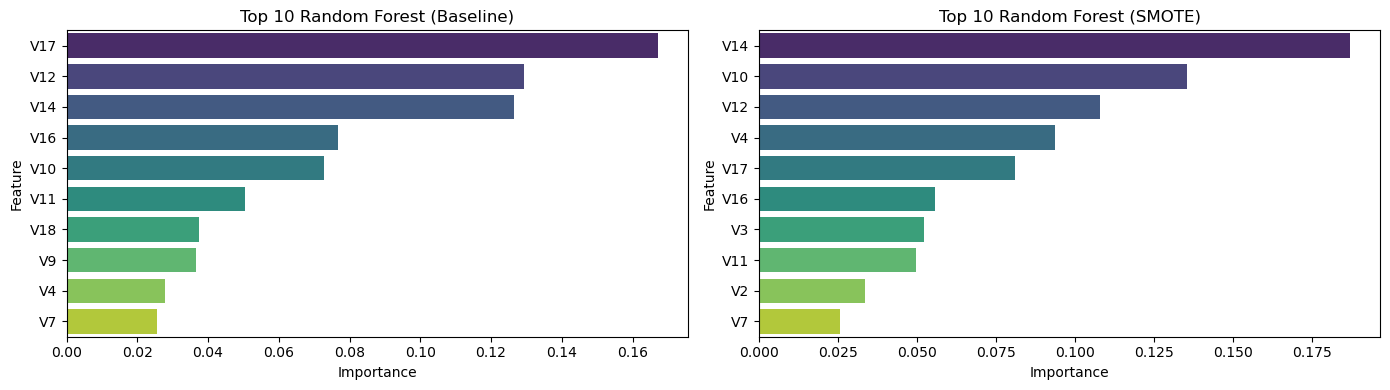

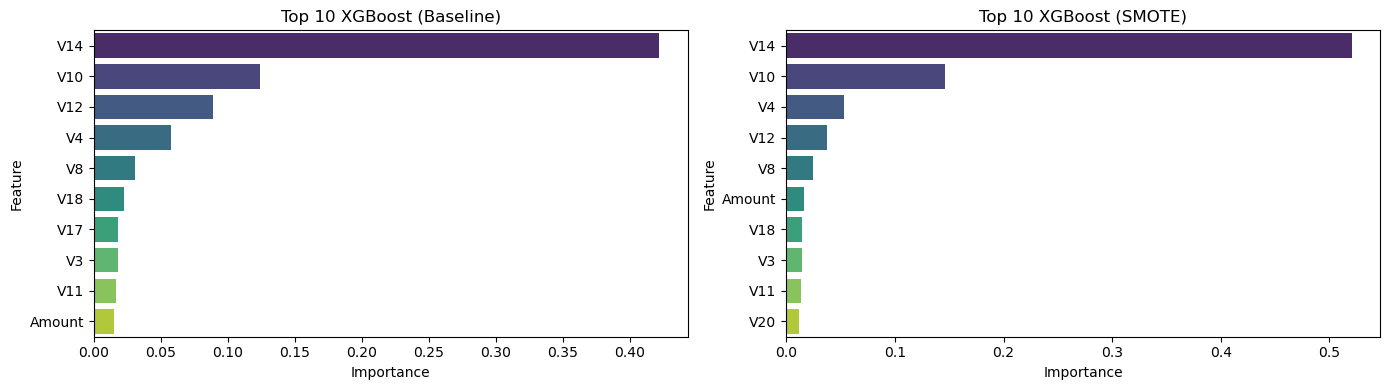

In [48]:
plot_feature_importances_comparison(rf, best_rf_pipeline.named_steps["rf"], X_train_scaled, "Random Forest")

plot_feature_importances_comparison(xgb_smote, best_xgb, X_train_scaled, "XGBoost")